# Overhead EBUS-Climate Correlations
Previously, I created an area-weighted time series of CO$_{2}$ flux and Adam Phillip's climate indices. This gives us a picture of how the whole EBUS varies with a climate index predictor. However, it prevents us from getting a taste of the spatial correlations. Perhaps a relatively high correlation score is due to a very high correlated cluster. Perhaps there is a gradient in the correlations themselves. Perhaps there are some negative and some positive scores within a given system.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import cartopy.crs as ccrs
plt.style.use('ocn-clim')
import cartopy.feature as cfeature
import seaborn as sns
import glob

# Functions

In [2]:
def load_overhead_correlations(EBU, x, y, lag, smooth):
    """
    Loads in the results of the overhead correlation analysis that was
    run as a python script.
    
    EBU       : Acronym for the EBUS of interest.
    x         : Predictor variable for the gas flux (e.g. NPGO)
    y         : Dependent variable being predicted (e.g. FG_CO2, U)
    lag       : Lag in months applied
    smooth    : Smooth in months applied
    """
    filedir = '/glade/p/work/rbrady/EBUS_BGC_Variability/regional_regressions/'
    filepath = filedir + EBU + '/' + y + '/' + x + '/lag' + str(lag) + '/'
    if smooth == 0:
        filename = (filepath + x + '.' + y + '.' + EBU + 
                    '.*.unsmoothed_regional_regression.lag' +
                    str(lag) + '.nc')
    else:
        filename = (filepath + x + '.' + y + '.' + EBU + 
                    '.*.smoothed' + str(smooth) + '_regional_regression.lag' +
                    str(lag) + '.nc')
    ds = xr.open_mfdataset(filename, concat_dim='ensemble')
    return ds

In [3]:
ens = ['001', '002', '009', '010', '011',
       '012', '013', '014', '015', '016',
       '017', '018', '019', '020', '021',
       '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031',
       '032', '033', '034', '035', '101',
       '102', '103', '104', '105']

# Visualization: Individual Panels

In [11]:
EBU = 'HumCS'
VARX = 'NINO3'
VARY = 'U'
lag = 0
smooth = 0

In [13]:
ds = load_overhead_correlations(EBU, VARX, VARY, lag, smooth)
mask = ds['r'].sel(ensemble=0) # Use to re-nan things that aren't in region.
ds = ds.where(ds.p <= 0.1, -999)

/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


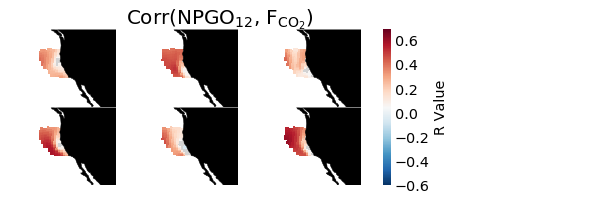

In [6]:
import matplotlib as mpl
f, axes = plt.subplots(nrows=2, ncols=3,
                       subplot_kw={'projection': ccrs.Mercator()},
                       gridspec_kw={'wspace':0.1, 'hspace':0},
                       figsize=(8,3))

st = f.suptitle('Corr(NPGO$_{12}$, F$_{\mathrm{CO}_{2}}$)', fontsize=20)
for i, ax in enumerate(axes.flat):
    data = ds['r'].sel(ensemble=i)
    data = np.ma.array(data, mask=np.isnan(mask))
    ax.outline_patch.set_edgecolor('w')    
    
    # r-value pcolormesh
    cmap = plt.cm.RdBu_r
    p = ax.pcolormesh(ds['TLONG']-1, ds['TLAT'], data, 
                      transform=ccrs.PlateCarree(), vmin=-0.6, vmax=0.7,
                      cmap=cmap)
    p.cmap.set_under('#d3d3d3')
    ax.add_feature(cfeature.LAND, facecolor='k')
    
    
    # Labels
    ax.text(-7, 30, str(ens[i]), color='w', transform=ccrs.Geodetic())

f.tight_layout()
f.subplots_adjust(top=0.85)
st.set_y(0.95)

# Colorbar
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cb = plt.colorbar(p, cax=cax, **kw)
cb.set_label('R Value')

# Visualization: Ensemble Mean Correlation

In [25]:
EBU = 'HumCS'
VARX = 'NINO3'
VARY = 'TAUX'
lag = 0
smooth = 0

In [26]:
ds = load_overhead_correlations(EBU, VARX, VARY, lag, smooth)
mask = ds['r'].sel(ensemble=0) # Use to re-nan things that aren't in region.
#ds = ds.where(ds.p >= 0.1, -999)
ds = ds.mean('ensemble')

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'HumCS Corr(TAUX,NINO3) Ensemble Mean')

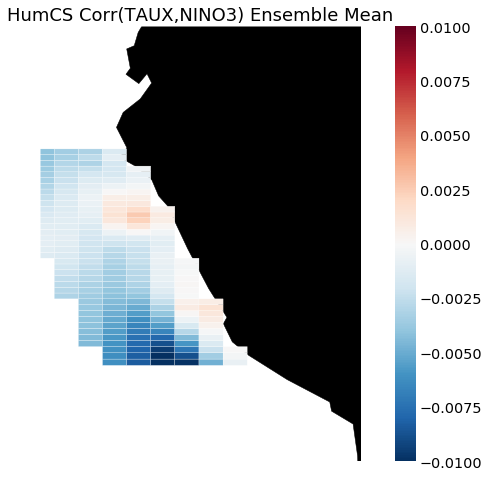

In [31]:
f, ax = et.vis.make_cartopy(projection=ccrs.Mercator(), frameon=False, grid_lines=False)

data = ds['m']
data = np.ma.array(data, mask=np.isnan(mask))
cmap = plt.cm.RdBu_r
p = ax.pcolor(ds['TLONG']-1, ds['TLAT'], data,
                  transform=ccrs.PlateCarree(), edgecolor='w',
                 cmap=cmap, vmin=-0.01, vmax=0.01)
ax.outline_patch.set_edgecolor('w')

# Aesthetics
x1,x2,y1,y2 = et.ebus.visual_bounds(EBU)
ax.set_extent([x1,x2,y1,y2])

# Colorbar
cb = plt.colorbar(p)
ax.set_title(EBU + ' Corr(' + VARY + ',' + VARX + ') Ensemble Mean',
             fontsize=18)

#et.vis.savefig('humcs_grid_TAUX_nino3', extension='.eps', dpi=300)